In [65]:
import pandas as pd
import numpy as np
import re

import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline

import folium
import folium.plugins as plugins

## Wczytanie i przegląd danych

In [66]:
df = pd.read_csv('./data/DataWorkshop.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229929 entries, 0 to 229928
Data columns (total 30 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Data zdarzenia                     229929 non-null  object 
 1   Godzina                            229929 non-null  object 
 2   GPS x                              229929 non-null  object 
 3   GPS y                              229929 non-null  object 
 4   Miejscowość                        229929 non-null  object 
 5   Ulica                              209201 non-null  object 
 6   Numer domu                         136045 non-null  object 
 7   Numer drogi                        229929 non-null  object 
 8   KM HM (Pikietaż)                   35041 non-null   object 
 9   Obszar                             229928 non-null  object 
 10  Skrzyżowanie                       63150 non-null   object 
 11  Geometria drogi                    1639

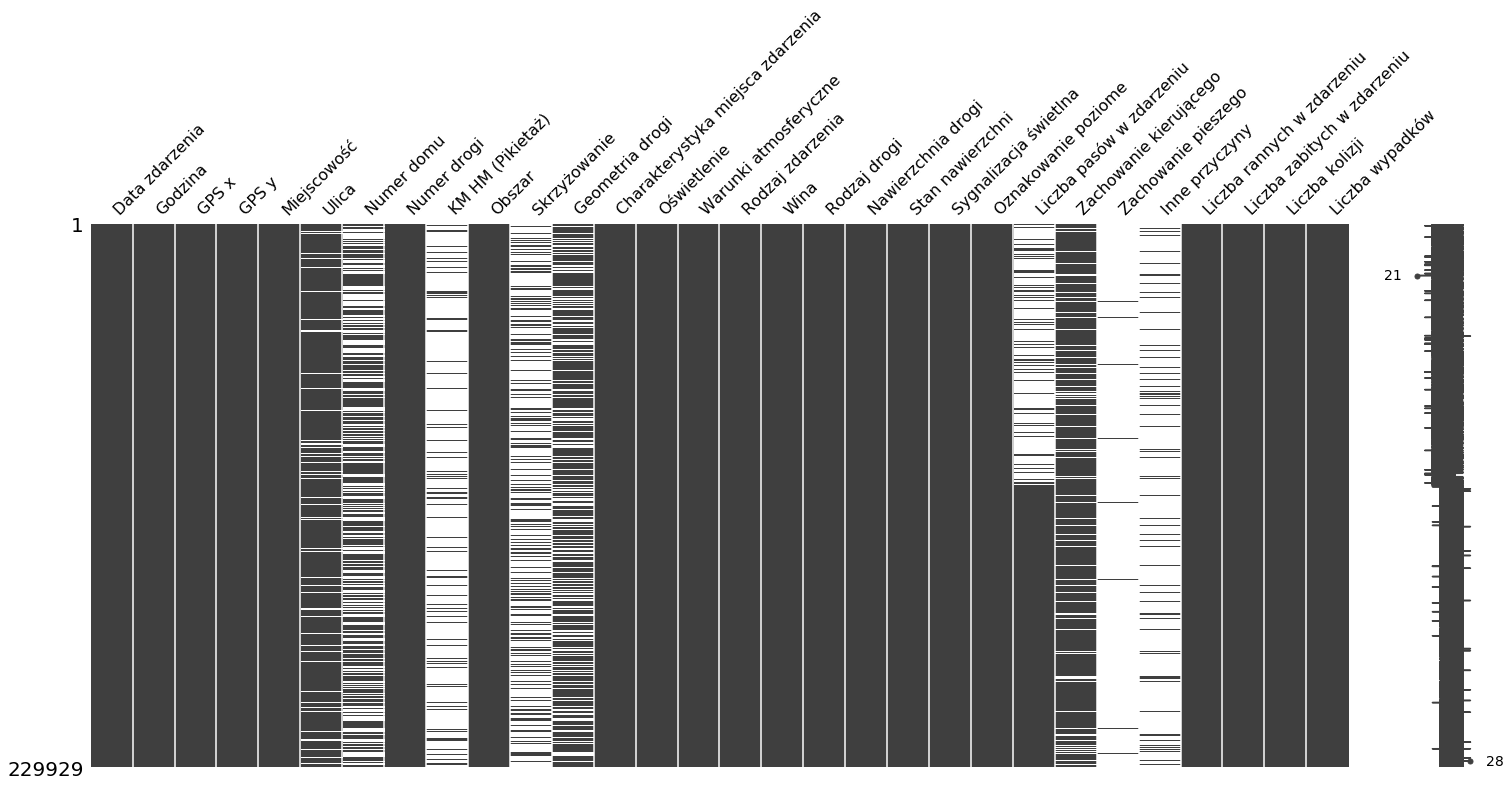

In [67]:
msno.matrix(df);

In [68]:
def check_missing():
    for column in df.columns:
        missing_items = df[column].isnull().sum()
        missing = column, missing_items, missing_items/df.shape[0]*100  
        if missing[1] == 0: continue

        print(missing)
        
check_missing()

('Ulica', 20728, 9.014956791009398)
('Numer domu', 93884, 40.8317350138521)
('KM HM (Pikietaż)', 194888, 84.76007811106908)
('Obszar', 1, 0.0004349168656411327)
('Skrzyżowanie', 166779, 72.53499993476247)
('Geometria drogi', 66008, 28.707992467239883)
('Charakterystyka miejsca zdarzenia', 2, 0.0008698337312822654)
('Warunki atmosferyczne', 1, 0.0004349168656411327)
('Rodzaj drogi', 1, 0.0004349168656411327)
('Nawierzchnia drogi', 1, 0.0004349168656411327)
('Stan nawierzchni', 1, 0.0004349168656411327)
('Oznakowanie poziome', 2, 0.0008698337312822654)
('Liczba pasów w zdarzeniu', 88154, 38.33966137372841)
('Zachowanie kierującego', 27901, 12.134615468253243)
('Zachowanie pieszego', 227444, 98.91923158888179)
('Inne przyczyny', 203726, 88.6038733696054)


In [69]:
df.shape[0]

229929

In [70]:
df.sample(3)

,Data zdarzenia,Godzina,GPS x,GPS y,Miejscowość,Ulica,Numer domu,Numer drogi,KM HM (Pikietaż),Obszar,...,Sygnalizacja świetlna,Oznakowanie poziome,Liczba pasów w zdarzeniu,Zachowanie kierującego,Zachowanie pieszego,Inne przyczyny,Liczba rannych w zdarzeniu,Liczba zabitych w zdarzeniu,Liczba kolizji,Liczba wypadków
175802,2019-02-12,07:40:00,18*53'067,50*16'523,RUDA ŚLĄSKA,CHORZOWSKA,NaN,P8423S,NaN,Obszar zabudowany,...,Brak,Jest,2.0,Nieprawidłowe skręcanie,NaN,NaN,0,0,1,0
66115,2017-04-02,09:35:00,19*06'551,50*20'023,BĘDZIN,WŁADYSŁAWA JAGIEŁŁY,1,GMINNA,NaN,Obszar zabudowany,...,Brak,Nie ma,NaN,Nieprawidłowe omijanie,NaN,NaN,0,0,1,0
68191,2017-04-14,20:50:00,18*28'280,50*00'198,WODZISŁAW ŚLĄSKI,WINCENTEGO WITOSA,28,I2,NaN,Obszar zabudowany,...,Brak,Nie ma,NaN,Nieprawidłowe cofanie,NaN,NaN,0,0,1,0


## Porządkowanie danych

In [71]:
# rename columns
def remove_accents(input_text):
    strange='ąćęłńóśźż'
    ascii_replacements='acelnoszz'
    translator=str.maketrans(strange,ascii_replacements)
    return input_text.translate(translator)
    
    return input_text.translate(translator)
def df_clean_header(x):
    x = x.strip()
    x = x.lower()
    x = x.replace(" ", "_")
    return removeAccents(x)

df.rename(columns=lambda x: df_clean_header(x), inplace=True)
df.columns

Index(['data_zdarzenia', 'godzina', 'gps_x', 'gps_y', 'miejscowosc', 'ulica',
       'numer_domu', 'numer_drogi', 'km_hm_(pikietaz)', 'obszar',
       'skrzyzowanie', 'geometria_drogi', 'charakterystyka_miejsca_zdarzenia',
       'oswietlenie', 'warunki_atmosferyczne', 'rodzaj_zdarzenia', 'wina',
       'rodzaj_drogi', 'nawierzchnia_drogi', 'stan_nawierzchni',
       'sygnalizacja_swietlna', 'oznakowanie_poziome',
       'liczba_pasow_w_zdarzeniu', 'zachowanie_kierujacego',
       'zachowanie_pieszego', 'inne_przyczyny', 'liczba_rannych_w_zdarzeniu',
       'liczba_zabitych_w_zdarzeniu', 'liczba_kolizji', 'liczba_wypadkow'],
      dtype='object')

### Data i czas

In [72]:
# zebranie daty i godziny w jedną kolumnę:

# df['data'] = df['data_zdarzenia'] + ' '+ df['godzina']
# df['data'] = pd.to_datetime(df['data'])

if 'data_zdarzenia' in df.columns: 
    df['data'] = df['data_zdarzenia'] + ' '+ df['godzina']
    df['data'] = pd.to_datetime(df['data'])
    del df['data_zdarzenia']
    del df['godzina']


df['rok'] = pd.DatetimeIndex(df['data']).year
df['miesiac'] = pd.DatetimeIndex(df['data']).month
df['godzina'] = pd.DatetimeIndex(df['data']).hour
df['minuta'] = pd.DatetimeIndex(df['data']).minute
df['pelna_data'] = pd.DatetimeIndex(df['data']).date # żeby rozróżnić dzień miesiąca, ex. 2019-05-18

#Który to był dzień tygodnia? poniedziałek = 0, niedziela = 6
df['dzien_tygodnia'] = pd.DatetimeIndex(df['data']).dayofweek

#Czy to był weekend?
df['czy_weekend'] = df['dzien_tygodnia'].apply(lambda x: 1 if (x == 6 or x == 5 ) else 0 )



In [73]:
time_feats = ['data', 'rok','miesiac','godzina', 'minuta','pelna_data','dzien_tygodnia','czy_weekend']
df[time_feats].sample(3)

,data,rok,miesiac,godzina,minuta,pelna_data,dzien_tygodnia,czy_weekend
11161,2016-03-26 14:00:00,2016,3,14,0,2016-03-26,5,1
186537,2019-04-19 12:00:00,2019,4,12,0,2019-04-19,4,0
172818,2019-01-25 03:20:00,2019,1,3,20,2019-01-25,4,0


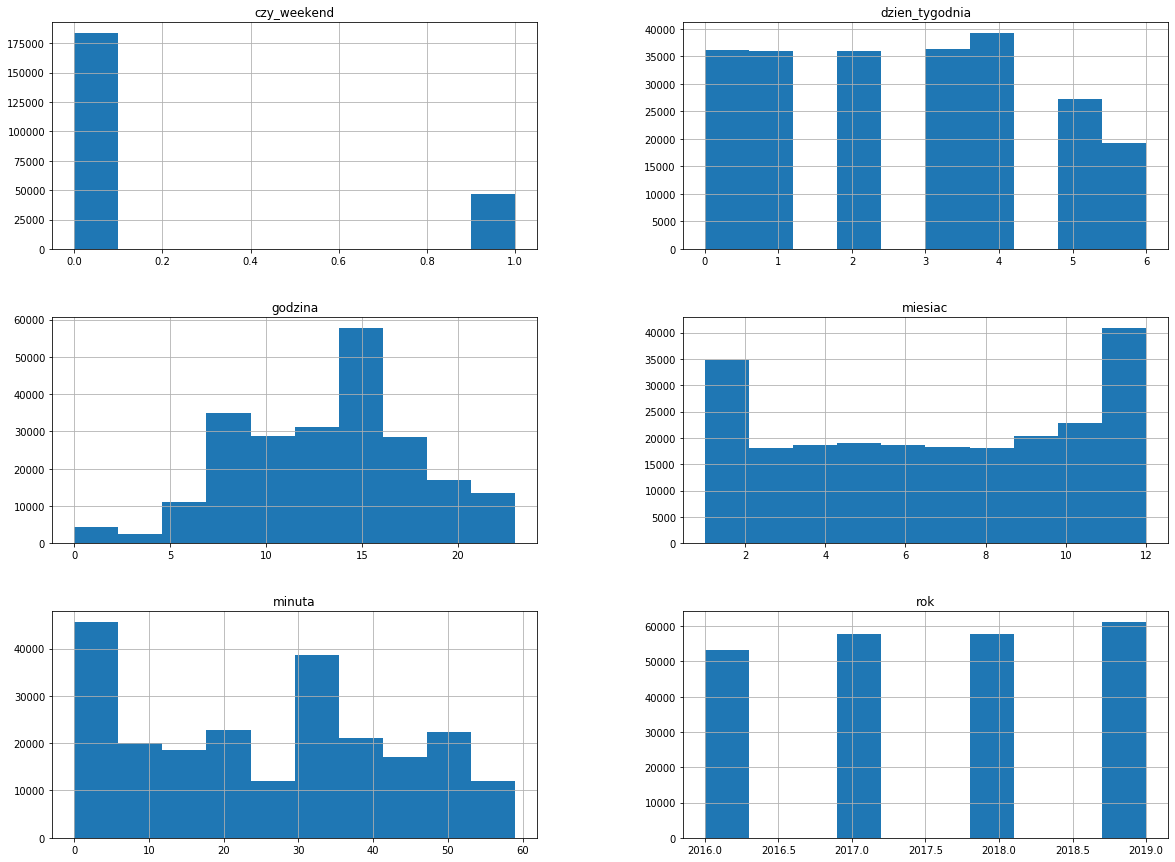

In [74]:
df[time_feats].hist(figsize=(20,15))
#plt.tight_layout()
plt.show()

### Współrzędne GPS

### Konwersja HH.MM.SS.S -> DD

In [77]:
# https://stackoverflow.com/questions/33997361
def dms2dd(coord):
    """ GPS HH.MM.SS.S to DD (Decimal Degrees) conversion """
    c = re.findall(r"\w+", coord)
    degrees = float(c[0])
    minutes = float(c[1])
    if len(c) > 2:
        seconds = float(c[2])/10   
    else:
        seconds = 0
    
    dd = float(degrees) + (minutes)/60 + float(seconds)/(60*60)

    return dd

df['lat'] = df['gps_y'].apply(lambda x : dms2dd(x)) # Latitude - N
df['lon'] = df['gps_x'].apply(lambda x : dms2dd(x)) # Longitude - E

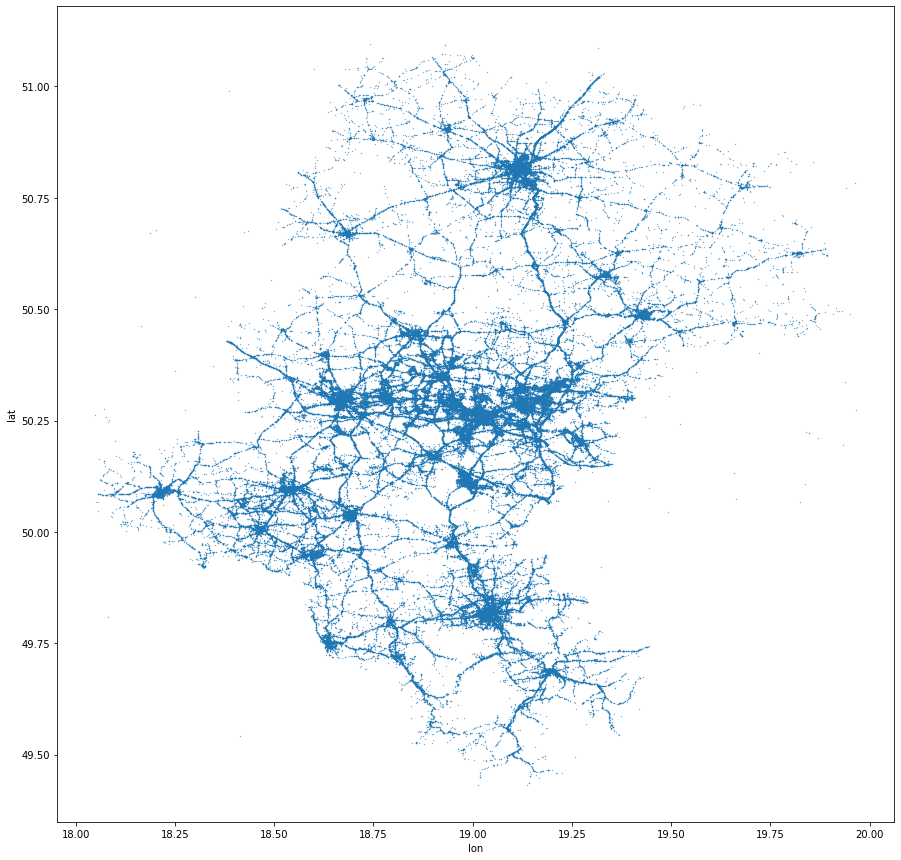

In [91]:
def plot_sca_map():
    dfmap = df.copy()

    dfmap.drop(dfmap[dfmap['lat'] < 49.393889].index, inplace=True)
    dfmap.drop(dfmap[dfmap['lat'] > 51.099167].index, inplace=True)
    dfmap.drop(dfmap[dfmap['lon'] < 18.035].index, inplace=True)
    dfmap.drop(dfmap[dfmap['lon'] > 19.973889].index, inplace=True)

    fig, ax = plt.subplots(figsize = (15, 15))
    dfmap.plot(kind='scatter', x='lon', y='lat', alpha=0.8, s=0.1, ax = ax)
    plt.show()
    
plot_sca_map()    

### Poprawa błędów

In [75]:
def clean_gps(x):
    s = re.sub(r"\d+",'', x)
    #print(s)
    return s

#clean_gps("50*15'068")
# prawidłowe formatowanie: *'
df['gps_err_y'] = df['gps_y'].apply(lambda x : clean_gps(x))
df['gps_err_x'] = df['gps_x'].apply(lambda x : clean_gps(x))

print('gps_err_y: ', df['gps_err_y'].unique(),'gps_err_x:',df['gps_err_x'].unique())

gps_err_y:  ["*'" "**'" "*'*" "*''"] gps_err_x: ["*'" "*''"]


In [78]:
feats = ["miejscowosc","ulica", "gps_x", "gps_x", "lat", "lon"]
df[feats][(df['gps_err_y']=="**'") | (df['gps_err_y']=="*'*") | (df['gps_err_y']=="*''") | (df['gps_err_x']=="*''")]

,miejscowosc,ulica,gps_x,gps_x,lat,lon
31931,WODZISŁAW ŚLĄSKI,ARMII KRAJOWEJ,18*28''05,18*28''05,50.013083,18.466806
135253,JASTRZĘBIE-ZDRÓJ,WIELKOPOLSKA,18*35'410,18*35'410,4.949139,18.594722
142857,JAWORZNO,NaN,19*15'220,19*15'220,50.150028,19.256111
149393,ŚWIĘTOCHŁOWICE,BYTOMSKA,18*55'084,18*55'084,50.300306,18.919000
161201,ZAWIERCIE,JÓZEFA PIŁSUDSKIEGO,19*25'274,19*25'274,50.417417,19.424278


In [54]:
nok_lst = [135253,161201]

#Manual Fix:
df.iloc[135253, df.columns.get_loc('gps_y')] = "49*56'569"

Współrzędne geograficzne skrajnych punktów:

    północny: 51°05′57″ szer. geogr. N – nurt Warty w pn.-wsch. narożniku działki ewidencyjnej nr 18/1 (powiat kłobucki),
    południowy: 49°23′38″ szer. geogr. N – słupek graniczny nr 161/6 (powiat żywiecki),
    zachodni: 18°02′06″ dług. geogr. E – słupek graniczny nr 45/5 (powiat raciborski),
    wschodni: 19°58′26″ dług. geogr. E – pn.-wsch. narożnik działki ewidencyjnej nr 124 (powiat zawierciański).

In [88]:
# bbox Silesian Voivodeship, Poland
#bbox = min Longitude , min Latitude , max Longitude , max Latitude 
#bbox = [18.035, 49.3939, 19.9741, 51.0995] - wg OSM

N = dms2dd("51°05′57")
S = dms2dd("49°23′38")
W = dms2dd("18°02′06")
E = dms2dd("19°58′26")

print(W,S,E,N)

bbox = [18.035, 49.3939, 19.9741, 51.0995] # wg OSM

feats = ["miejscowosc","ulica","numer_drogi", "gps_x", "gps_y","lat", "lon"]
df[feats][(df['lon'] < 18.035) | (df['lat'] < 49.3939) | (df['lon'] > 19.9741) | (df['lat'] > 51.0995)]

18.0335 49.384388888888886 19.967388888888888 51.08491666666667


,miejscowosc,ulica,numer_drogi,gps_x,gps_y,lat,lon
15349,KATOWICE,TRASA NIKODEMA I JÓZEFA RENCÓW,W902,19*59'033,50*16'087,50.269083,19.984250
20566,GLIWICE,LITERATÓW,I2,17*38'271,50*20'080,50.335556,17.640861
27105,OSINY,CZĘSTOCHOWSKA,791,19*23'227,51*33'157,51.554361,19.389639
32758,KONIECPOL,RYNEK,794,15*40'354,50*46'170,50.771389,15.676500
32880,ZABRZE,NaN,A4,21*59'567,50*20'277,50.341028,21.999083
34895,BONOWICE,NaN,78,16*46'322,50*37'081,50.618917,16.775611
37291,KATOWICE,NaN,A4,15*59'547,50*15'097,50.252694,15.998528
45271,KATOWICE,BRYNOWSKA,P6453S,19*59'452,50*14'025,50.234028,19.995889
49595,SKRZYDLÓW,GŁÓWNA,GMINNA,19*20'439,51*12'202,51.205611,19.345528
86014,MYKANÓW,NaN,1,19*20'260,50*90'457,51.512694,19.340556


In [89]:
fix_lst = df[feats][(df['lon'] < 18.035) | (df['lat'] < 49.3939) | (df['lon'] > 19.9741) | (df['lat'] > 51.0995)].index.to_numpy()
print(fix_lst)

# CZĘSTOCHOWSKA, OSINY, silesian voivodeship, Poland


# https://github.com/stemaan/infoshare_webinar

array([ 15349,  20566,  27105,  32758,  32880,  34895,  37291,  45271,
        49595,  86014, 120955, 122869, 131415, 134588, 135253, 139483,
       145949, 146928, 147956, 155437, 160399, 161478, 161915, 162191,
       173479, 203804], dtype=int64)

### Sprawdzenie

In [22]:
feats = ["Miejscowość","Ulica", "GPS x", "GPS y", "Lat", "Lon"]
df[feats][(df['GPSy']=="**'") | (df['GPSy']=="*'*") | (df['GPSy']=="*''") | (df['GPSx']=="*''")]

,Miejscowość,Ulica,GPS x,GPS y,Lat,Lon
31931,WODZISŁAW ŚLĄSKI,ARMII KRAJOWEJ,18*28''05,50*00'471,50.013083,18.466806
135253,JASTRZĘBIE-ZDRÓJ,WIELKOPOLSKA,18*35'410,4**56'569,4.949139,18.594722
142857,JAWORZNO,NaN,19*15'220,50*09'*01,50.150028,19.256111
149393,ŚWIĘTOCHŁOWICE,BYTOMSKA,18*55'084,50*18''11,50.300306,18.919000
161201,ZAWIERCIE,JÓZEFA PIŁSUDSKIEGO,19*25'274,50*25''27,50.417417,19.424278


In [63]:
gps_lst = [31931, 135253, 142857, 149393, 161201]

# 135253 - 49*56'569

def osm_url(i):
    lat = df.iloc[i].Lat
    lon = df.iloc[i].Lon
    print(f"http://www.openstreetmap.org/?mlat={lat}&mlon={lon}&zoom=20&layers=M")

for item in gps_lst:     
    osm_url(item)

http://www.openstreetmap.org/?mlat=50.013083333333334&mlon=18.466805555555553&zoom=20&layers=M
http://www.openstreetmap.org/?mlat=4.949138888888889&mlon=18.59472222222222&zoom=20&layers=M
http://www.openstreetmap.org/?mlat=50.15002777777778&mlon=19.25611111111111&zoom=20&layers=M
http://www.openstreetmap.org/?mlat=50.30030555555555&mlon=18.919&zoom=20&layers=M
http://www.openstreetmap.org/?mlat=50.41741666666666&mlon=19.424277777777778&zoom=20&layers=M


In [75]:
import random

r = random.randint(0,df.shape[0])

print(df.iloc[r].Miejscowość,':', df.iloc[r].Ulica) 
osm_url(r)

ZAWIERCIE : EMILA ZEGADŁOWICZA
http://www.openstreetmap.org/?mlat=50.48291666666667&mlon=19.424972222222223&zoom=20&layers=M


In [123]:
#123623 	2018-03-27 	12:15:00 	19*01'261 	50*15'068 	KATOWICE 	POWSTAŃCÓW 	NaN 	P6503S
        
print(dms2dd("50*15'068"))
print(dms2dd("19*01'261"))

50.25188888888889
19.023916666666665


In [188]:
#df['Data zdarzenia'] = pd.to_datetime(df['Data zdarzenia']) 
#df['Godzina'] = pd.to_datetime(df['Godzina']) 


df['Lat'] = pd.to_numeric(df['Lat'], downcast='float')
df['Lon'] = pd.to_numeric(df['Lon'], downcast='float')
df['Liczba rannych w zdarzeniu'] = pd.to_numeric(df['Liczba rannych w zdarzeniu'], downcast='unsigned')
df['Liczba zabitych w zdarzeniu'] = pd.to_numeric(df['Liczba zabitych w zdarzeniu'], downcast='unsigned')
df['Liczba kolizji'] = pd.to_numeric(df['Liczba kolizji'], downcast='unsigned')
df['Liczba wypadków'] = pd.to_numeric(df['Liczba wypadków'], downcast='unsigned')

### Adres

In [28]:
print('kolumna Miejscowość : ', df['Miejscowość'].dtypes)
print('kolumna Ulica : ', df['Ulica'].dtypes)
print('kolumna Numer domu : ', df['Numer domu'].dtypes)
print('kolumna Numer drogi: ', df['Numer drogi'].dtypes)

kolumna Miejscowość :  object
kolumna Ulica :  object
kolumna Numer domu :  object
kolumna Numer drogi:  object


### Pikietaż

In [45]:
print('kolumna KM HM (Pikietaż): ', df['KM HM (Pikietaż)'].dtypes)
print('Przykładowe wartości z tej kolumny: ', df['KM HM (Pikietaż)'][df['KM HM (Pikietaż)'].notnull()].sample(3))

kolumna KM HM (Pikietaż):  float32
Przykładowe wartości z tej kolumny:  25776       0.500000
154697    515.000000
28757     548.599976
Name: KM HM (Pikietaż), dtype: float32


In [44]:
df['KM HM (Pikietaż)'] = df['KM HM (Pikietaż)'].apply(lambda x : str(x).replace(',','.'))
df['KM HM (Pikietaż)'] = df['KM HM (Pikietaż)'].astype(float)
df['KM HM (Pikietaż)'] = pd.to_numeric(df['KM HM (Pikietaż)'], downcast='float')

### Obszar

In [54]:
def area(x):
    if str(x) == 'Obszar zabudowany': return 1
    if str(x) == 'Obszar niezabudowany': return 0
    if str(x) == 'nan': return -1

print(df['Obszar'].unique())
df['Obszar'] = df['Obszar'].apply(lambda x : area(x)) 

['Obszar niezabudowany' 'Obszar zabudowany' nan]


In [55]:
print(df['Obszar'].unique())

[ 0  1 -1]


### Skrzyżowanie

In [56]:
df['Skrzyżowanie'].unique()

array([nan, 'Z drogą z pierwsz.', 'O ruchu okrężnym', 'Równorzędne'],
      dtype=object)

In [57]:
# 0 : O ruchu okrężnym | 1 : Równorzędne | 2 : Z drogą z pierwsz.
def crossing(x):
    if str(x) == 'O ruchu okrężnym': return 0
    if str(x) == 'Równorzędne': return 1
    if str(x) == 'Z drogą z pierwsz.': return 2
    if str(x) == 'nan': return -1

print(df['Skrzyżowanie'].unique())
df['Skrzyżowanie'] = df['Skrzyżowanie'].apply(lambda x : crossing(x)) 

[nan 'Z drogą z pierwsz.' 'O ruchu okrężnym' 'Równorzędne']


In [58]:
print(df['Skrzyżowanie'].unique())

[-1  2  0  1]


### Geometria drogi

In [59]:
df['Geometria drogi'].unique()

array(['Odcinek prosty', nan, 'Zakręt, łuk', 'Spadek', 'Wzniesienie',
       'Wierzchołek wzn.', 'Zakręt, łuk; Spadek',
       'Odcinek prosty; Spadek', 'Zakręt, łuk; Wzniesienie',
       'Odcinek prosty; Wzniesienie', 'Zakręt, łuk; Wierzchołek wzn.',
       'Odcinek prosty; Wierzchołek wzn.', 'Odcinek prosty; Zakręt, łuk'],
      dtype=object)

In [60]:
df['Charakterystyka miejsca zdarzenia'].unique()

array(['Jezdnia', 'Chodnik, droga dla pieszych', 'Parking, plac',
       'Wjazd, wyjazd z posesji, pola', 'Parking, plac, MOP (od 11.2015)',
       'Skarpa, rów', 'Pobocze', 'Przejście dla pieszych',
       'Most, wiadukt, łącznica, tunel', 'Pas dzielący jezdnie',
       'Przejazd kolejowy strzeżony', 'Przejazd tramwajowy, torowisko',
       'Przystanek komunikacji publicznej', 'Droga dla rowerzystów',
       'Przejazd kolejowy niestrzeżony',
       'Roboty drogowe, oznakowanie tymczasowe',
       'Droga, pas ruchu, śluza dla rowerów (od 11.2015)',
       'Przejazd dla rowerzystów (od 11.2015)',
       'Przewiązka na drodze dwujezdniowej', 'Parking, plac, MOP',
       'Przejazd tramwajowy, torowisko tramwajowe',
       'Droga, pas ruchu, śluza dla rowerów', 'Przejazd dla rowerzystów',
       nan], dtype=object)

In [62]:
df['Oświetlenie'].unique()
## TODO: Dzień  / NOC / Oswietlona

array(['Noc - droga nieoświetlona', 'Noc - droga oświetlona',
       'Światło dzienne', 'Zmrok, świt', 'Świt, zmrok'], dtype=object)

In [63]:
df['Warunki atmosferyczne'].unique()

array(['Dobre warunki atmosferyczne', 'Pochmurno', 'Mgła, dym',
       'Oślepiające słońce', 'Opady śniegu, gradu',
       'Pochmurno; Opady śniegu, gradu', 'Opady deszczu',
       'Opady deszczu; Opady śniegu, gradu', 'Pochmurno; Opady deszczu',
       'Pochmurno; Mgła, dym', 'Pochmurno; Opady deszczu; Mgła, dym',
       'Opady deszczu; Mgła, dym',
       'Pochmurno; Opady deszczu; Opady śniegu, gradu',
       'Silny wiatr; Pochmurno; Opady śniegu, gradu',
       'Pochmurno; Opady śniegu, gradu; Mgła, dym',
       'Opady śniegu, gradu; Mgła, dym', 'Silny wiatr',
       'Silny wiatr; Opady deszczu', 'Silny wiatr; Pochmurno',
       'Silny wiatr; Opady śniegu, gradu',
       'Oślepiające słońce; Silny wiatr',
       'Silny wiatr; Pochmurno; Opady deszczu',
       'Oślepiające słońce; Opady deszczu', nan,
       'Silny wiatr; Opady deszczu; Opady śniegu, gradu',
       'Silny wiatr; Pochmurno; Opady deszczu; Opady śniegu, gradu',
       'Opady deszczu; Opady śniegu, gradu; Mgła, dym'], d

In [64]:
df['Rodzaj zdarzenia'].unique()

array(['Najechanie na zwierzę', 'Najechanie na pojazd unieruchomiony',
       'Zderzenie pojazdów tylne', 'Najechanie na słup, znak',
       'Zderzenie pojazdów boczne', 'Najechanie na barierę ochronną',
       'Inne', 'Najechanie na dziurę, wybój, garb',
       'Najechanie na pieszego', 'Wywrócenie się pojazdu',
       'Zderzenie pojazdów czołowe', 'Najechanie na drzewo',
       'Najechanie na zapore kolejową', 'Zdarzenie z pasażerem'],
      dtype=object)

In [65]:
df['Wina'].unique()

array(['z innych przyczyn', 'z winy kierującego',
       'współwina uczestników ruchu', 'z winy pieszego'], dtype=object)

In [66]:
df['Rodzaj drogi'].unique()

array(['Jednojezdniowa dwukierunkowa', 'Jednokierunkowa', 'Autostrada',
       'Dwie jezdnie jednokierunkowe', 'Ekspresowa', nan], dtype=object)

In [67]:
df['Nawierzchnia drogi'].unique()

array(['Twarda', 'Gruntowa', nan], dtype=object)

In [68]:
df['Stan nawierzchni'].unique()

array(['Sucha', 'Mokra', 'Oblodzona, zaśnieżona',
       'Mokra; Oblodzona, zaśnieżona', 'Koleiny, garby',
       'Zanieczyszczona', 'Mokra; Koleiny, garby',
       'Oblodzona, zaśnieżona; Dziury, wyboje', 'Mokra; Dziury, wyboje',
       'Kałuże, rozlewiska', 'Kałuże, rozlewiska; Oblodzona, zaśnieżona',
       'Mokra; Kałuże, rozlewiska', 'Zanieczyszczona; Dziury, wyboje',
       'Dziury, wyboje', 'Mokra; Kałuże, rozlewiska; Dziury, wyboje',
       'Sucha; Dziury, wyboje', 'Sucha; Zanieczyszczona',
       'Mokra; Kałuże, rozlewiska; Koleiny, garby',
       'Mokra; Zanieczyszczona',
       'Mokra; Zanieczyszczona; Koleiny, garby; Dziury, wyboje',
       'Mokra; Kałuże, rozlewiska; Oblodzona, zaśnieżona',
       'Mokra; Koleiny, garby; Dziury, wyboje',
       'Kałuże, rozlewiska; Dziury, wyboje',
       'Oblodzona, zaśnieżona; Zanieczyszczona; Koleiny, garby; Dziury, wyboje',
       'Zanieczyszczona; Koleiny, garby; Dziury, wyboje',
       'Mokra; Kałuże, rozlewiska; Zanieczyszczona; Kol

In [69]:
df['Sygnalizacja świetlna'].unique()

array(['Brak', 'Jest, nie działa', 'Jest, działa'], dtype=object)

In [ ]:
#stwórzmy dodatkową kolumnę sygnalizacja_dziala
#df['sygnalizacja_dziala'] =  

#zamieńmy wartości na zmienne 0 i 1 (sygnalizacja jest/nie ma)

In [70]:
df['Liczba pasów w zdarzeniu'].unique()

array([  2.,  nan,   1.,   3.,   4.,   5.,   6.,   8.,   7.,   0.,   9.,
       250.,  50.,  24.,  90.,  12.,  60.,  20.,  70.,  40.,  18.,  13.,
        10.,  14.,  17.,  66.,  11.,  16.,  25.,  22.,  32.,  30.,  67.,
        15.])

In [71]:
df['Zachowanie kierującego'].unique()

array([nan, 'Nieprawidłowe: cofanie', 'Nieprawidłowe: omijanie',
       'Niedostosowanie prędkości do warunków ruchu',
       'Nieudzielenie pierwszeństwa przejazdu',
       'Inne przyczyny (od 11.2015)',
       'Niezachowanie bezp. odl. między pojazdami',
       'Nieprawidłowe: skręcanie', 'Nieprawidłowe: zmienianie pasa ruchu',
       'Zmęczenie, zaśnięcie', 'Nieprawidłowe: wymijanie',
       'Nieprzestrzeganie innych sygnałów',
       'Niestosowanie się do sygnalizacji świetlnej (od 11.2015)',
       'Nieustąpienie pierwszeństwa pieszemu na przejściu dla pieszych (od 11.2015)',
       'Gwałtowne hamowanie', 'Nieprawidłowe: wyprzedzanie',
       'Nieprawidłowe: zatrzymywanie, postój',
       'Nieprawidłowe: wymijanie; Nieprawidłowe: wymijanie',
       'Nieprawidłowe: cofanie; Nieprawidłowe: cofanie',
       'Nieprawidłowe: Zawracanie',
       'Nieprawidłowe: skręcanie; Nieprawidłowe: skręcanie',
       'Nieustąpienie pierwszeństwa pieszemu w innych okolicznościach (od 11.2015)',
    

In [72]:
df['Zachowanie pieszego'].unique()

array([nan, 'Wejście na jezdnię przy czerwonym świetle',
       'Przekraczanie jezdni w miejscu niedozwolonym',
       'Nieostrożne wejście na jezdnię: przed jadącym pojazdem',
       'Inne przyczyny (od 11.2015)',
       'Nieostrożne wejście na jezdnię: zza pojazdu, przeszkody',
       'Chodzenie nieprawidłową stroną drogi',
       'Stanie na jezdni, leżenie',
       'Nieostrożne wejście na jezdnię: przed jadącym pojazdem; Nieostrożne wejście na jezdnię: przed jadącym pojazdem',
       'Zatrzymanie, cofnięcie się',
       'Przekraczanie jezdni w miejscu niedozwolonym; Przekraczanie jezdni w miejscu niedozwolonym',
       'Inne przyczyny',
       'Leżenie, siedzenie, klęczenie, stanie na jezdni',
       'Nieostrożne wejście na jezdnię: zza pojazdu, przeszkody; Nieostrożne wejście na jezdnię: zza pojazdu, przeszkody',
       'Wejście na jezdnię przy czerwonym świetle; Wejście na jezdnię przy czerwonym świetle',
       'Inne przyczyny; Inne przyczyny',
       'Chodzenie nieprawidłową str

In [73]:
df['Inne przyczyny'].unique()

array(['Obiekty, zwierzęta na drodze', nan, 'Nieustalone',
       'Niewłaściwy stan jezdni', 'Inne',
       'Utrata przytomności, śmierć kierującego (od 11.2015)',
       'Pożar pojazdu', 'Nieprawidłowo zabezp. roboty drogowe',
       'Niesprawność techniczna pojazdu (od 11.2015)', 'Z winy pasażera',
       'Oślepienie przez inny pojazd lub słońce',
       'Nieprawidłowo działająca zapora, rogatka', 'Stan jezdni',
       'Niesprawność techniczna pojazdu',
       'Zabezpieczenie robót na drodze',
       'Utrata przytomności, śmierć kierującego', 'Organizacja ruchu',
       'Nieprawidłowo działająca zapora kolej.',
       'Działanie sygnalizacji świetlnej'], dtype=object)

In [77]:
print(df['Liczba rannych w zdarzeniu'].unique())
df['ranni'] = df['Liczba rannych w zdarzeniu']

[ 0  4  1  2  3  6  5  9 11  8 26  7 10 12]


In [78]:
print(df['Liczba zabitych w zdarzeniu'].unique())
df['zabici'] = df['Liczba zabitych w zdarzeniu']

[0 1 2 4 3]


In [80]:
print(df['Liczba kolizji'].unique())
df['kolizje'] = df['Liczba kolizji']

[1 0]


In [81]:
print(df['Liczba wypadków'].unique())
df['wypadki'] = df['Liczba wypadków']

[0 1]


In [82]:
#df.fillna(-1)

# Dane drogi

In [139]:
# conda install -c conda-forge osmnx 
import osmnx as ox
place = "Katowice, Poland"

useful_tags_path = ['bridge', 'tunnel', 'oneway', 'lanes', 'name',
                    'highway', 'maxspeed', 'service', 'access', 'area',
                    'landuse', 'width', 'est_width', 'junction', 'surface','traffic_signals','crossing', 'give_way' ]
ox.utils.config(useful_tags_path=useful_tags_path)

# G = ox.graph_from_address('350 5th Ave, New York, New York', network_type='drive')
graph = ox.graph_from_place(place, network_type='drive')

In [142]:
nodes, streets = ox.graph_to_gdfs(graph)
streets.sample(5)

,u,v,key,osmid,lanes,surface,name,oneway,highway,maxspeed,length,geometry,junction,tunnel,bridge,access,width
10474,2366963590,2366963560,0,228044697,NaN,NaN,Karola Stabika,False,residential,NaN,95.405,"LINESTRING (18.97510 50.19324, 18.97522 50.192...",NaN,NaN,NaN,NaN,NaN
1081,4865312883,2496705459,0,494781333,NaN,paving_stones,Brynicy,False,residential,NaN,22.489,"LINESTRING (19.09554 50.26738, 19.09566 50.26757)",NaN,NaN,NaN,NaN,NaN
5699,4135527187,1690780322,0,156840308,NaN,NaN,Aleksandra Baumgardtena,False,residential,NaN,77.511,"LINESTRING (18.97912 50.20398, 18.98020 50.20403)",NaN,NaN,NaN,NaN,NaN
5090,1523523609,4499159268,0,373404362,NaN,asphalt,Olimpijska,False,residential,NaN,98.096,"LINESTRING (19.02908 50.26666, 19.02905 50.266...",NaN,NaN,NaN,NaN,NaN
3791,1896520051,1896520081,0,166907115,NaN,NaN,Gliwicka,False,tertiary,NaN,70.030,"LINESTRING (18.96659 50.27208, 18.96669 50.272...",NaN,NaN,NaN,NaN,NaN


### Zdarzenie

In [128]:
df.iloc[123623]

Data zdarzenia                                                        2018-03-27
Godzina                                                                 12:15:00
GPS x                                                                  19*01'261
GPS y                                                                  50*15'068
Miejscowość                                                             KATOWICE
Ulica                                                                 POWSTAŃCÓW
Numer domu                                                                   NaN
Numer drogi                                                               P6503S
KM HM (Pikietaż)                                                             NaN
Obszar                                                                         1
Skrzyżowanie                                                                   2
Geometria drogi                                                              NaN
Charakterystyka miejsca zdar

In [109]:
# https://www.openstreetmap.org/way/238171637
# https://www.openstreetmap.org/query?lat=50.25191&lon=19.02391
# http://overpass-turbo.eu/
    # highway=traffic_signals
    # highway=crossing
    # highway=give_way
    

# https://towardsdatascience.com/loading-data-from-openstreetmap-with-python-and-the-overpass-api-513882a27fd0

# osmid: 51342495 / 238171638
    
streets[streets['name'] == 'Powstańców']

,u,v,key,osmid,oneway,lanes,ref,name,highway,maxspeed,length,geometry,junction,tunnel,bridge,access,width
1029,1927350344,1837481557,0,238171637,False,3,NaN,Powstańców,tertiary,50,109.807,"LINESTRING (19.02821 50.25166, 19.02741 50.251...",NaN,NaN,NaN,NaN,NaN
1030,1927350344,1837481553,0,"[205489645, 238171637]",False,3,NaN,Powstańców,tertiary,50,105.285,"LINESTRING (19.02821 50.25166, 19.02862 50.251...",NaN,NaN,NaN,NaN,NaN
1909,1837517954,4077376661,0,172908536,True,2,NaN,Powstańców,tertiary,NaN,13.301,"LINESTRING (19.03315 50.25125, 19.03297 50.25127)",NaN,NaN,NaN,NaN,NaN
3145,4077376661,2096966277,0,172908536,True,2,NaN,Powstańców,tertiary,NaN,50.560,"LINESTRING (19.03297 50.25127, 19.03293 50.251...",NaN,NaN,NaN,NaN,NaN
3194,655185124,655185128,0,577690554,True,NaN,NaN,Powstańców,unclassified,30,65.773,"LINESTRING (19.02123 50.25211, 19.02206 50.252...",NaN,NaN,NaN,NaN,NaN
3196,655185128,2121589599,0,51342495,True,NaN,NaN,Powstańców,unclassified,30,123.523,"LINESTRING (19.02215 50.25204, 19.02222 50.252...",NaN,NaN,NaN,NaN,NaN
5731,2121589598,1837481561,0,238171638,True,2,NaN,Powstańców,unclassified,30,66.461,"LINESTRING (19.02395 50.25191, 19.02405 50.251...",NaN,NaN,NaN,NaN,NaN
5732,2121589599,2121589598,0,238171638,True,2,NaN,Powstańców,unclassified,30,5.686,"LINESTRING (19.02387 50.25191, 19.02395 50.25191)",NaN,NaN,NaN,NaN,NaN
6784,2096966263,2096966261,0,205489644,True,1,NaN,Powstańców,tertiary,NaN,11.053,"LINESTRING (19.03313 50.25116, 19.03328 50.25115)",NaN,NaN,NaN,NaN,NaN
6809,2096966277,2096966263,0,199712525,True,2,NaN,Powstańców,tertiary,NaN,63.771,"LINESTRING (19.03226 50.25130, 19.03284 50.251...",NaN,NaN,NaN,NaN,NaN


In [137]:
streets[(streets.osmid == 51342495)]

,u,v,key,osmid,oneway,lanes,ref,name,highway,maxspeed,length,geometry,junction,tunnel,bridge,access,width
3196,655185128,2121589599,0,51342495,True,NaN,NaN,Powstańców,unclassified,30,123.523,"LINESTRING (19.02215 50.25204, 19.02222 50.252...",NaN,NaN,NaN,NaN,NaN


In [138]:
streets[(streets.osmid == 238171638)]

,u,v,key,osmid,oneway,lanes,ref,name,highway,maxspeed,length,geometry,junction,tunnel,bridge,access,width
5731,2121589598,1837481561,0,238171638,True,2,NaN,Powstańców,unclassified,30,66.461,"LINESTRING (19.02395 50.25191, 19.02405 50.251...",NaN,NaN,NaN,NaN,NaN
5732,2121589599,2121589598,0,238171638,True,2,NaN,Powstańców,unclassified,30,5.686,"LINESTRING (19.02387 50.25191, 19.02395 50.25191)",NaN,NaN,NaN,NaN,NaN
10230,1837481561,1837481558,0,238171638,True,2,NaN,Powstańców,unclassified,30,51.379,"LINESTRING (19.02488 50.25183, 19.02501 50.251...",NaN,NaN,NaN,NaN,NaN


In [112]:
streets.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 10580 entries, 0 to 10579
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   u         10580 non-null  int64   
 1   v         10580 non-null  int64   
 2   key       10580 non-null  int64   
 3   osmid     10580 non-null  object  
 4   oneway    10580 non-null  bool    
 5   lanes     2440 non-null   object  
 6   ref       237 non-null    object  
 7   name      9356 non-null   object  
 8   highway   10580 non-null  object  
 9   maxspeed  3041 non-null   object  
 10  length    10580 non-null  float64 
 11  geometry  10580 non-null  geometry
 12  junction  207 non-null    object  
 13  tunnel    43 non-null     object  
 14  bridge    193 non-null    object  
 15  access    106 non-null    object  
 16  width     1 non-null      object  
dtypes: bool(1), float64(1), geometry(1), int64(3), object(11)
memory usage: 1.3+ MB


In [127]:
#19*00'551 (E) 	50*16'127 (N) 	KATOWICE 	JANA NEPOMUCENA STĘŚLICKIEGO

m = folium.Map(
    location=[50.25188888888889, 19.023916666666665],
    zoom_start=20,
    tiles='Stamen Terrain'
)

tooltip = 'Wypadek'

folium.Marker([50.25188888888889, 19.023916666666665], popup='<i>ID : </i>', tooltip=tooltip).add_to(m)
#folium.Marker([45.3311, -121.7113], popup='<b>Timberline Lodge</b>', tooltip=tooltip).add_to(m)

m

